In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

from utils.common import *

# Load Data

In [2]:
ohlc = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\dataCleaned\\poloniex\\5min\\USDT_BTC_5min_2016-01-01_2017-12-31.tsv', sep='\t')\
    .query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)

# EMA

In [19]:
def calculate_EMA(history, col, time_period):
    return calculateTalib('EMA', {col: history[col].values}, {'timeperiod': time_period})

def add_EMA(df):
    df['blue'] = calculate_EMA(df, 'close', 8)
    df['green'] = calculate_EMA(df, 'close', 13)
    df['yellow'] = calculate_EMA(df, 'close', 21)
    df['red'] = calculate_EMA(df, 'close', 55)
    return df

In [39]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc['timestamp'] = usdtBtc.date.apply(str_time_to_timestamp).astype(int)

usdtBtc = add_EMA(usdtBtc)
ohlc = add_EMA(ohlc)

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)
ohlcTrain = ohlc.iloc[:trainSize]
ohlcTest = ohlc.iloc[trainSize:]

features = ['red', 'yellow', 'green', 'blue']
usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain[features])
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest[features])
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [21]:
usdtBtc

,date,close,return,return_1,return_2,zscore_36_return,zscore_288_return,pma36,ma_12_108,ma_36_288,...,zscore_2016_volume,vol36,vol288,vol2016,dv_36_288,timestamp,blue,green,yellow,red
0,2017-01-01 00:00:00,964.0000,0.0012,0.0000,-0.0012,1.3564,0.6427,0.5949,0.5238,0.5238,...,-0.5479,-2.1082,-0.6513,-1.9766,0.1077,1483225200,nan,nan,nan,nan
1,2017-01-01 00:05:00,962.8600,-0.0012,0.0012,0.0000,-1.6326,-0.6611,0.2303,0.4765,0.4765,...,-0.5386,-2.0828,-0.6572,-1.9430,0.0973,1483225500,nan,nan,nan,nan
2,2017-01-01 00:10:00,962.8600,0.0000,-0.0012,0.0012,-0.1397,-0.0055,0.1835,0.4303,0.4303,...,-0.5124,-2.3351,-0.6541,-1.9234,0.0997,1483225800,nan,nan,nan,nan
3,2017-01-01 00:15:00,964.0000,0.0012,0.0000,-0.0012,1.4824,0.6468,0.4751,0.4135,0.4135,...,-0.5393,-2.3506,-0.6364,-1.8926,0.1244,1483226100,nan,nan,nan,nan
4,2017-01-01 00:20:00,965.0000,0.0010,0.0012,0.0000,1.3116,0.5634,0.7164,0.4211,0.4211,...,-0.1465,-2.3032,-0.6216,-1.9982,0.1445,1483226400,nan,nan,nan,nan
5,2017-01-01 00:25:00,965.0000,0.0000,0.0010,0.0012,-0.3003,-0.0089,0.6704,0.4109,0.4109,...,-0.5201,-2.3151,-0.6315,-1.9999,0.1274,1483226700,nan,nan,nan,nan
6,2017-01-01 00:30:00,965.0000,0.0000,0.0000,0.0010,-0.2629,-0.0064,0.6309,0.4084,0.4084,...,-0.5486,-2.2990,-0.6412,-1.9904,0.1108,1483227000,nan,nan,nan,nan
7,2017-01-01 00:35:00,963.0463,-0.0020,0.0000,0.0000,-3.3193,-1.1232,0.0247,0.3991,0.3991,...,-0.5437,-2.0928,-0.5976,-1.9433,0.1746,1483227300,963.9708,nan,nan,nan
8,2017-01-01 00:40:00,965.0050,0.0020,-0.0020,0.0000,2.5758,1.1120,0.5662,0.4164,0.4164,...,-0.4757,-1.9491,-0.5543,-1.9102,0.2368,1483227600,964.2006,nan,nan,nan
9,2017-01-01 00:45:00,965.0050,0.0000,0.0020,-0.0020,-0.1966,-0.0089,0.5279,0.4198,0.4198,...,-0.5481,-1.9455,-0.5490,-1.8914,0.2420,1483227900,964.3794,nan,nan,nan


# Explore

In [ ]:
%matplotlib notebook

In [ ]:
usdtBtcR.columns

In [ ]:
usdtBtcR.iloc[190:, :]

In [ ]:
step = 361
day = 288
i = day * step
j = i + day
usdtBtcR = usdtBtc.iloc[i:j, :]

paper_rc = {'lines.linewidth': 0.5, 'lines.markersize': 1}                  
sns.set_context("paper", rc = paper_rc) 

fig, ax = plotCandles(ohlc.iloc[i:j, :])
ax2 = ax.twinx()
sns.pointplot(usdtBtcR.timestamp.values, usdtBtcR['vol36'].values, ax=ax2)
sns.pointplot(usdtBtcR.timestamp.values, usdtBtcR['zscore_36_return'].values, ax=ax2, color='green')

set_date_axis(usdtBtcR['timestamp'], ax, fig)

True

# Implementation

In [72]:
from copy import deepcopy

class CustomStrategy:
    def __init__(self, exchange, dataManager, contractPair, tradeSize, willingLoss, targetProfit):
        self.exchange = exchange
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = dataManager
        self.historyLen = 1
        self.contractPair = contractPair
        self.opened = False
        self.tradeSize = tradeSize
        self.willingLoss = willingLoss
        self.targetProfit = targetProfit
    
    
    def isRisky(self, priceBought, actualPrice):
        return self.currentReturn(priceBought, actualPrice) < -self.willingLoss 
    
    
    def currentReturn(self, priceBought, actualPrice):
        feePart = (1 - self.exchange.fee) ** 2
        returnPart = (actualPrice * feePart) / priceBought
        return returnPart - 1
    
    
    def sellWhole(self, price):
        self.opened = False
        amount = self.exchange.balance(self.contractPair['tradeContract'])
        self.exchange.sell(self.contractPair, amount, price)
    
    
    def buy(self, price):
        amount = self.tradeSize / price
        self.exchange.buy(self.contractPair, amount, price)
        self.opened = True
        
        fee = self.exchange.fee
        breakEvenPrice = price / ((1 - fee) ** 2)
#         print('price', price, 'breakEven', breakEvenPrice)
        return breakEvenPrice
        
    
    def isTargetSatisffied(self, priceBought, price):
        return self.currentReturn(priceBought, price) >= self.targetProfit
    
    
    def currentTime(self):
        return self.dataManager.time
    
    def timeExceeded(self, timeBought):
        return (self.currentTime() - timeBought) > self.historyLen
    
    @staticmethod
    def isCorrectOrder(red, yellow, green, blue):
        return red < yellow < green < blue
    
    def trade(self):
        
        inRow = 0
        while self.dataManager.has_tick():            
            history, price = self.dataManager.tick(self.historyLen)
            
            if history.shape[0] == 0:
                continue
            
            red, yellow, green, blue = history[0]
            if np.isnan(red) :
                continue

            if self.isCorrectOrder(red, yellow, green, blue):
                inRow += 1
            else :
                inRow = 0
            
            
            if not self.opened and inRow >= 5:
                breakEvenPrice = self.buy(price)
                priceBought = price
                timeBought = self.currentTime()
            elif self.opened and (self.isRisky(priceBought, price)):
#                 print(self.dataManager.time, 'stopLoss: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)
            elif self.opened and self.isTargetSatisffied(priceBought, price):
                self.sellWhole(price)
            elif self.opened and not self.isCorrectOrder(red, yellow, green, blue):
#                 print(self.dataManager.time, 'profit: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)
        
        if self.opened:
            self.sellWhole(price)

                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)

# Learning

In [74]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = CustomStrategy(exchange, dataManager, contractPair, 100, willingLoss=0.5, targetProfit=0.01)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,"1,608.0000"
totalProfit,-728.3901
avgProfit,-0.4530
winPercentage,21.3308
avgWinTrade,1.0867
avgLossTrade,-0.8705
profitFactor,0.3385
maxDrawdown,72.8536


In [6]:
exchange.wallet

{'btc': 0.0, 'usdt': 1048.877322934556}

In [9]:
import time, sys
DAY = 288

allStats = None
print('historyLen willingLoss distanceFromMaxThreshold1 distanceFromMaxThreshold2 targetProfit')
for historyLen in [DAY, 2*DAY, 3*DAY, 7*DAY]:
    for willingLoss in [.01, 0.02, .03, .05, .1, .2, .5]:
        distanceThresholds = [.01, .02, .03, .04, .05, 0.06, .07, .08]
        for distanceFromMaxThreshold1 in distanceThresholds:
            for distanceFromMaxThreshold2 in [x for x in distanceThresholds if x <= distanceFromMaxThreshold1]:
                for targetProfit in [.01, .02, .03, .04, .05, .07, .1, .2, .3]:
                    s = "\r{} {} {} {} {}".format(historyLen, willingLoss, distanceFromMaxThreshold1, 
                                                  distanceFromMaxThreshold2, targetProfit)
                    sys.stdout.write(s)
                    sys.stdout.flush()

                    start_time = time.time()
                    dataManager = deepcopy(usdtBtcManagerTrain)
                    exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
                    strategy = CustomStrategy(exchange, dataManager, historyLen, contractPair, 100, willingLoss=willingLoss, 
                                              distanceFromMaxThreshold1=distanceFromMaxThreshold1, 
                                              distanceFromMaxThreshold2=distanceFromMaxThreshold2, 
                                              targetProfit=targetProfit)
                    strategy.trade()
                    stats = strategy.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
                    stats['historyLen'] = historyLen
                    stats['willingLoss'] = willingLoss
                    stats['distanceFromMaxThreshold1'] = distanceFromMaxThreshold1
                    stats['distanceFromMaxThreshold2'] = distanceFromMaxThreshold2
                    stats['targetProfit'] = targetProfit
                    if allStats is None:
                        allStats = stats
                    else:
                        allStats = allStats.append(stats)
                    sys.stdout.write(s + "\t %.2f seconds" % (time.time() - start_time))
                    sys.stdout.flush()
            

allStats.to_csv('D:\\Dropbox\\My work\\krypl-project\\result\\customStrategy.tsv', index=False, sep='\t')

historyLen willingLoss distanceFromMaxThreshold1 distanceFromMaxThreshold2 targetProfit
2016 0.5 0.08 0.08 0.3	 0.97 seconds

# Look on transactions

In [7]:
len(strategy.exchange.transactions)

64

In [8]:
strategy.exchange.transactions[2:4]

[{'amount': 0.1069319377032782,
  'fee': 0.25,
  'pair': {'priceContract': 'usdt', 'tradeContract': 'btc'},
  'price': 935.1743001,
  'timestamp': 6080,
  'type': 'BUY'},
 {'amount': 0.1069319377032782,
  'fee': 0.24327015827495793,
  'pair': {'priceContract': 'usdt', 'tradeContract': 'btc'},
  'price': 910.0,
  'timestamp': 6211,
  'type': 'SELL'}]

In [11]:
usdtBtcTrain.head()

,date,close,return,return_1,return_2,zscore_36_return,zscore_288_return,pma36,ma_12_108,ma_36_288,ac36,ac288,zscore_36_volume,zscore_288_volume,zscore_2016_volume,vol36,vol288,vol2016,dv_36_288,timestamp
0,2017-01-01 00:00:00,964.0000,0.0012,0.0000,-0.0012,1.3564,0.6427,0.5949,0.5238,0.5238,-0.2330,1.1830,-0.9252,-0.6178,-0.5479,-2.1082,-0.6513,-1.9766,0.1077,1483225200
1,2017-01-01 00:05:00,962.8600,-0.0012,0.0012,0.0000,-1.6326,-0.6611,0.2303,0.4765,0.4765,-0.1632,1.1759,-0.7954,-0.5869,-0.5386,-2.0828,-0.6572,-1.9430,0.0973,1483225500
2,2017-01-01 00:10:00,962.8600,0.0000,-0.0012,0.0012,-0.1397,-0.0055,0.1835,0.4303,0.4303,-0.0648,1.1684,-0.4472,-0.5038,-0.5124,-2.3351,-0.6541,-1.9234,0.0997,1483225800
3,2017-01-01 00:15:00,964.0000,0.0012,0.0000,-0.0012,1.4824,0.6468,0.4751,0.4135,0.4135,0.0272,1.1620,-0.7797,-0.5863,-0.5393,-2.3506,-0.6364,-1.8926,0.1244,1483226100
4,2017-01-01 00:20:00,965.0000,0.0010,0.0012,0.0000,1.3116,0.5634,0.7164,0.4211,0.4211,0.1321,1.1566,4.7744,0.6743,-0.1465,-2.3032,-0.6216,-1.9982,0.1445,1483226400


<IPython.core.display.Javascript object>


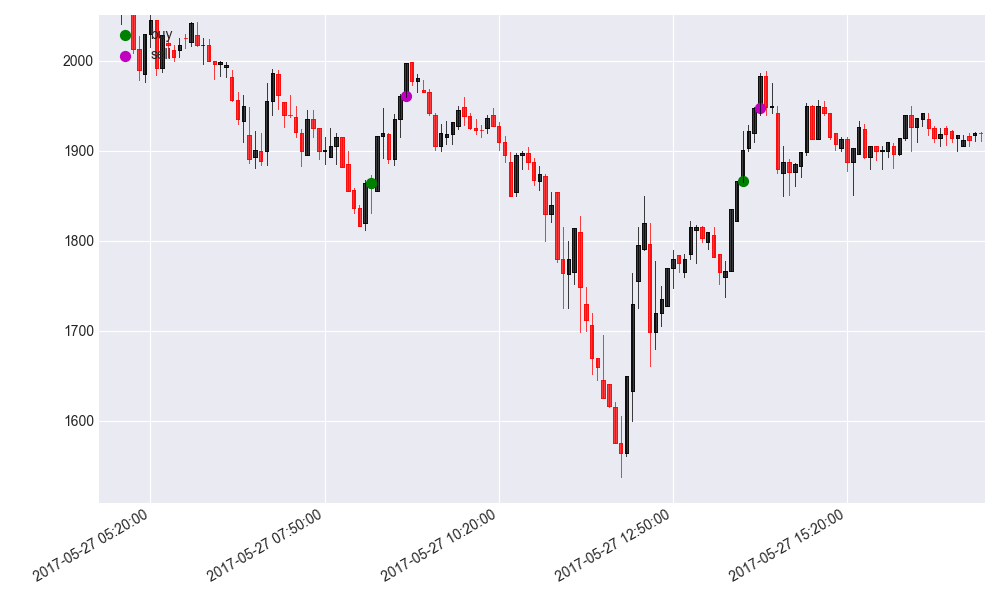

In [9]:
%matplotlib notebook
plot_transactions(ohlcTrain, strategy.exchange.transactions[:])

In [ ]:
t = 70

transaction = strategy.exchange.transactions[t]
plotTransactionWithSurroundings(ohlcTrain, strategy.historyLen, transaction)
transaction = strategy.exchange.transactions[t+1]
plotTransactionWithSurroundings(ohlcTrain, strategy.historyLen, transaction)

In [ ]:
transaction

# Evaluate Distance From Max

In [15]:
allStats = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\result\\customStrategy.tsv',sep='\t')

In [ ]:
allStats.query('totalProfit > 90 and winPercentage > 70').sort_values('numberOfTrades', ascending=False)

In [16]:
allStats.sort_values('totalProfit', ascending=False).query('willingLoss < 0.1').query('winPercentage > 50')

,contract,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,historyLen,willingLoss,distanceFromMaxThreshold1,distanceFromMaxThreshold2,targetProfit
7760,usdt,"1,000.0000",32.0000,48.8773,1.5274,65.6250,4.1328,-3.4464,2.2893,1.0158,2016,0.0300,0.0800,0.0700,0.0300
7956,usdt,"1,000.0000",52.0000,46.9991,0.9038,86.5385,1.9173,-5.6117,2.1965,1.0252,2016,0.0500,0.0600,0.0600,0.0100
3272,usdt,"1,000.0000",25.0000,46.6079,1.8643,56.0000,7.9344,-5.8612,1.7229,1.7316,576,0.0500,0.0300,0.0100,0.0700
8021,usdt,"1,000.0000",40.0000,45.8253,1.1456,70.0000,3.9912,-5.4939,1.6951,2.5223,2016,0.0500,0.0700,0.0700,0.0300
8083,usdt,"1,000.0000",31.0000,44.3496,1.4306,80.6452,3.0468,-5.3035,2.3937,1.4579,2016,0.0500,0.0800,0.0700,0.0200
7958,usdt,"1,000.0000",41.0000,44.3236,1.0811,70.7317,3.8443,-5.5967,1.6600,1.9802,2016,0.0500,0.0600,0.0600,0.0300
7633,usdt,"1,000.0000",48.0000,42.9780,0.8954,68.7500,2.8853,-3.4824,1.8228,1.5635,2016,0.0300,0.0600,0.0600,0.0200
3281,usdt,"1,000.0000",28.0000,42.2616,1.5093,53.5714,7.9030,-5.8680,1.5540,1.7434,576,0.0500,0.0300,0.0200,0.0700
7634,usdt,"1,000.0000",45.0000,41.6832,0.9263,60.0000,3.8095,-3.3985,1.6814,1.8610,2016,0.0300,0.0600,0.0600,0.0300
7310,usdt,"1,000.0000",51.0000,41.5831,0.8154,50.9804,4.0100,-2.5071,1.6634,1.6345,2016,0.0200,0.0600,0.0600,0.0300


In [18]:
dataManager = deepcopy(usdtBtcManagerTest)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = CustomStrategy(exchange, dataManager, 2016, contractPair, 100, willingLoss=0.05, 
                                   distanceFromMaxThreshold1=0.06, distanceFromMaxThreshold2=0.03, targetProfit=0.01)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,7.0000
totalProfit,5.7388
avgProfit,0.8198
winPercentage,85.7143
avgWinTrade,1.8997
avgLossTrade,-5.6597
profitFactor,2.0140
maxDrawdown,0.5660
